**Análise de Funil e Impacto da Fonte (A/A/B)**

Este projeto tem como objetivo principal analisar o comportamento dos usuários de nosso aplicativo de venda de produtos alimentícios. A análise será dividida em duas etapas cruciais: a avaliação do funil de vendas para identificar gargalos na jornada de compra e a verificação dos resultados de um teste A/A/B implementado para avaliar o impacto de uma mudança nas fontes do aplicativo na experiência e conversão do usuário.

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest


df = pd.read_csv('../data/processed/logs_exp_us_processado.csv', sep='\t')
df

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   eventname       244126 non-null  object
 1   deviceidhash    244126 non-null  int64 
 2   eventtimestamp  244126 non-null  int64 
 3   expid           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [85]:
# Organizando as colunas

df.columns = ['event_name', 'user_id', 'event_timestamp', 'experiment_id']
print(df.columns)

Index(['event_name', 'user_id', 'event_timestamp', 'experiment_id'], dtype='object')


In [86]:
# Limpando os dados

print(df.isnull().sum())
print()
print(df.dtypes)


event_name         0
user_id            0
event_timestamp    0
experiment_id      0
dtype: int64

event_name         object
user_id             int64
event_timestamp     int64
experiment_id       int64
dtype: object


In [87]:
# Conversão da coluna event_timestamp para datetime

df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')
print(df['event_timestamp'].describe())



count                           244126
mean     2019-08-04 10:18:35.842716160
min                2019-07-25 04:43:36
25%      2019-08-02 14:36:20.249999872
50%                2019-08-04 11:49:55
75%                2019-08-06 06:55:11
max                2019-08-07 21:15:17
Name: event_timestamp, dtype: object


In [88]:
# Extração de data e hora do evento

df['event_date_time'] = df['event_timestamp']
df['event_date'] = df['event_timestamp'].dt.date
print(df[['event_date_time', 'event_date']].head())


      event_date_time  event_date
0 2019-07-25 04:43:36  2019-07-25
1 2019-07-25 11:11:42  2019-07-25
2 2019-07-25 11:28:47  2019-07-25
3 2019-07-25 11:28:47  2019-07-25
4 2019-07-25 11:48:42  2019-07-25


In [89]:
# Quantos eventos ficam nos registros?

total_eventos = len(df)
print(f"Total de eventos registrados: {total_eventos}")


Total de eventos registrados: 244126


In [90]:
# Quantos usuários ficam nos registros?

usuarios_unicos = df['user_id'].nunique()
print(f"Total de usuários únicos: {usuarios_unicos}")


Total de usuários únicos: 7551


In [91]:
# Qual é o número médio de eventos por usuário?

total_eventos = df.shape[0]
usuarios_unicos = df['user_id'].nunique()
media_eventos_por_usuario = total_eventos / usuarios_unicos
print(f"Média de eventos por usuário: {media_eventos_por_usuario:.2f}")


Média de eventos por usuário: 32.33


In [92]:
# Período de tempo dos dados

inicio = df['event_timestamp'].min()
fim = df['event_timestamp'].max()
print(f"Período dos dados: de {inicio} até {fim}")


Período dos dados: de 2019-07-25 04:43:36 até 2019-08-07 21:15:17


C:\Users\Usuário\AppData\Local\Temp\ipykernel_1304\320939244.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['event_hour'] = df['event_timestamp'].dt.floor('H')


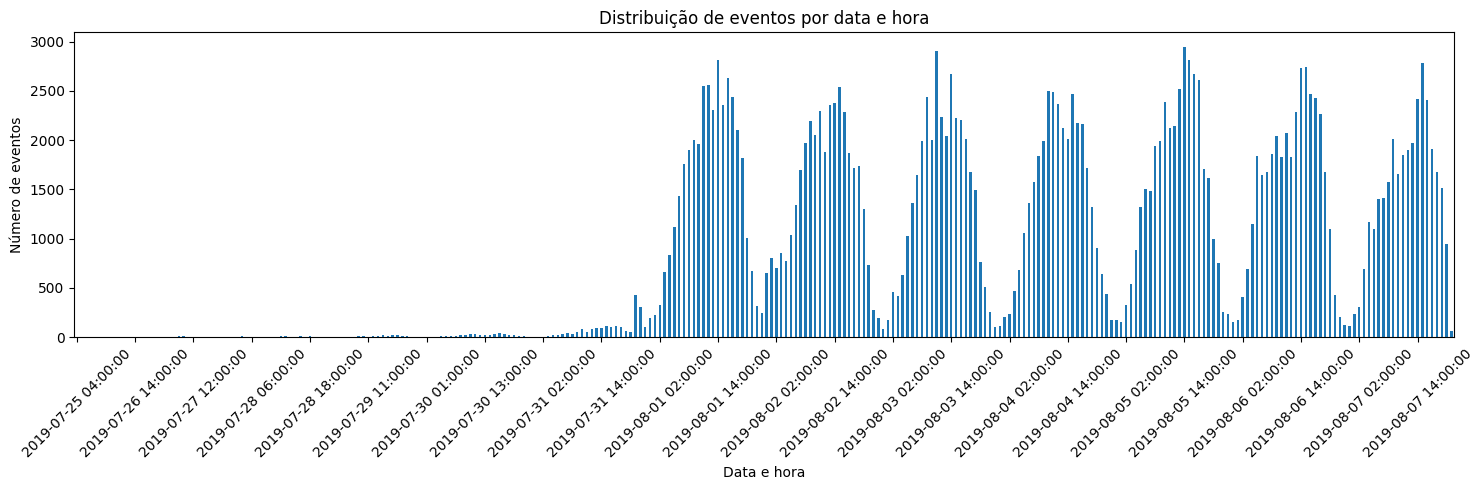

In [93]:
# Visualização da distribuição de eventos ao longo do tempo

df['event_hour'] = df['event_timestamp'].dt.floor('H') 

eventos_por_hora = df['event_hour'].value_counts().sort_index()

plt.figure(figsize=(15, 5))
eventos_por_hora.plot(kind='bar')
plt.title('Distribuição de eventos por data e hora')
plt.xlabel('Data e hora')
plt.ylabel('Número de eventos')
plt.xticks(ticks=range(0, len(eventos_por_hora), 12), labels=eventos_por_hora.index[::12], rotation=45)
plt.tight_layout()
plt.show()


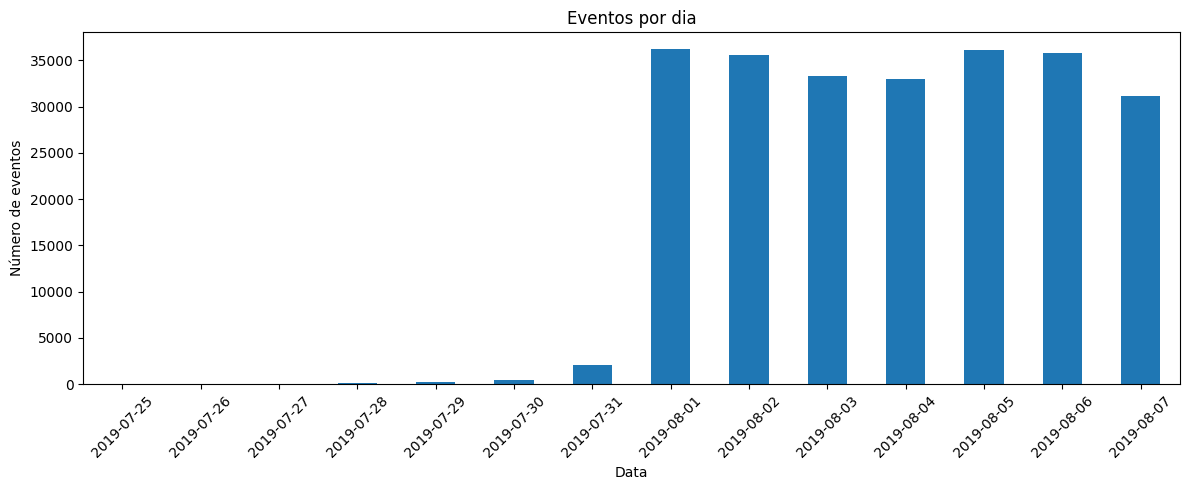

Resumo de eventos por dia:
count       14.000000
mean     17437.571429
std      17734.124149
min          9.000000
25%        124.750000
50%      16587.500000
75%      35042.250000
max      36229.000000
Name: count, dtype: float64


In [94]:
# Contagem de eventos por data

eventos_por_dia = df['event_date'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
eventos_por_dia.plot(kind='bar')
plt.title('Eventos por dia')
plt.xlabel('Data')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Resumo de eventos por dia:")
print(eventos_por_dia.describe())


<Axes: title={'center': 'Usuários únicos por dia'}, xlabel='event_date'>

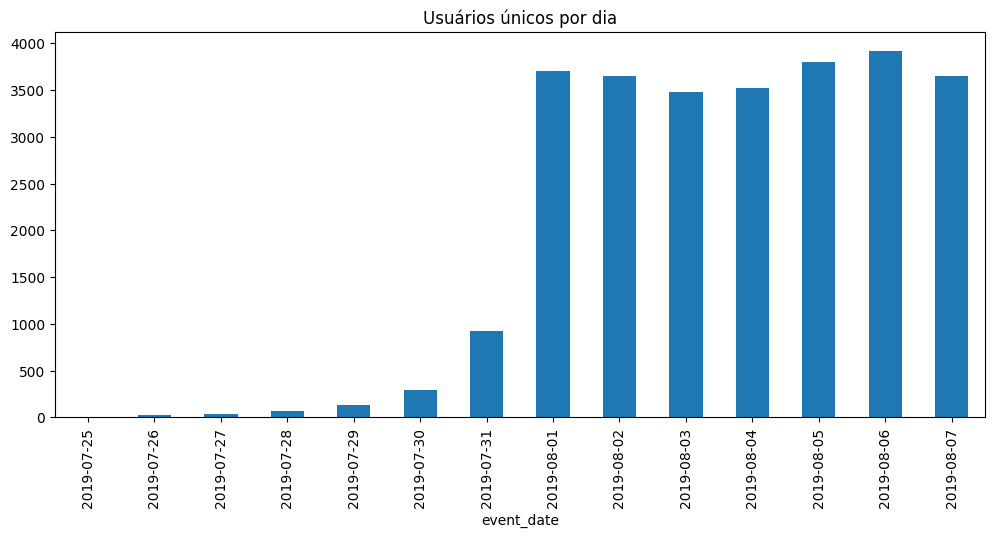

In [95]:
# Contagem de usuários únicos por dia

usuarios_por_dia = df.groupby('event_date')['user_id'].nunique()
usuarios_por_dia.plot(kind='bar', figsize=(12,5), title='Usuários únicos por dia')


In [96]:
# Contagem de eventos por dia

eventos_por_dia = df['event_date'].value_counts().sort_index()
print(eventos_por_dia)


event_date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
Name: count, dtype: int64


In [97]:
# Filtrando dados a partir do dia 1 de agosto de 2019
# Considero que antes desta data os dados são bem escassos e portanto não são significativos para impactar a análise - abaixo terá a quantidade de eventos perdidos

df = df[df['event_date'] >= pd.to_datetime('2019-08-01').date()]

Considero que antes desta data de corte os dados são bem escassos e portanto não serão significativos a ponto de impactar a análise.
Logo abaixo trago o número de eventos perdidos - são poucos.


In [98]:
# Momento em que os dados começam a ser completos

inicio_real = df['event_timestamp'].min()
fim_real = df['event_timestamp'].max()
print(f"Período confiável dos dados: de {inicio_real.date()} até {fim_real.date()}")


Período confiável dos dados: de 2019-08-01 até 2019-08-07


In [99]:
# Eventos e usuários perdidos ao excluir os dados mais antigos

eventos_apos_corte = df.shape[0]
usuarios_apos_corte = df['user_id'].nunique()

eventos_perdidos = total_eventos - eventos_apos_corte
usuarios_perdidos = usuarios_unicos - usuarios_apos_corte

perc_eventos = eventos_perdidos / total_eventos * 100
perc_usuarios = usuarios_perdidos / usuarios_unicos * 100

print(f"Eventos perdidos: {eventos_perdidos} ({perc_eventos:.2f}%)")
print(f"Usuários perdidos: {usuarios_perdidos} ({perc_usuarios:.2f}%)")



Eventos perdidos: 2828 (1.16%)
Usuários perdidos: 17 (0.23%)


In [100]:
# Usuários por grupo experimental

usuarios_por_grupo = df.groupby('experiment_id')['user_id'].nunique()
print(usuarios_por_grupo)


experiment_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


In [101]:
# Passo 4 
# Eventos únicos por frequência

eventos_frequencia = df['event_name'].value_counts()
print(eventos_frequencia)


event_name
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: count, dtype: int64


In [102]:
# Calculando usuários únicos por evento

total_usuarios = df['user_id'].nunique()

usuarios_por_evento = df.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

proporcao_usuarios = (usuarios_por_evento / total_usuarios).sort_values(ascending=False)

funil_df = pd.DataFrame({
    'usuarios_unicos': usuarios_por_evento,
    'proporcao': proporcao_usuarios
})

funil_df['proporcao_percentual'] = (funil_df['proporcao'] * 100).round(2)

funil_df


,usuarios_unicos,proporcao,proporcao_percentual
event_name,,,
MainScreenAppear,7419,0.984736,98.47
OffersScreenAppear,4593,0.609636,60.96
CartScreenAppear,3734,0.495620,49.56
PaymentScreenSuccessful,3539,0.469737,46.97
Tutorial,840,0.111495,11.15


O funil parece estar bem saudável! A taxa de conversão geral é alta (~47%).

A maior queda está entre a MainScreen e a OffersScreen — talvez o app não esteja incentivando o clique ou mostrando bem os produtos.

Entre quem entra no carrinho e quem compra, a desistência é bem pequena, indicando boa experiência de compra.

#### Em que ordem as ações ocorreram?

1° MainScreenAppear - O app é iniciado e o usuário vê a tela principal. Ponto de entrada lógico.

2° OffersScreenAppear - O usuário navega pelas promoções ou produtos disponíveis.

3° CartScreenAppear - Após escolher produtos, ele acessa o carrinho para revisar a compra.

4°PaymentScreenSuccessful - O usuário finaliza a compra com sucesso.

5° Tutorial - Geralmente aparece apenas para novos usuários ou na primeira vez que o app é aberto.



In [103]:
# Proporção de usuários na etapa B para o número de usuários na etapa A e a proporção de usuários na etapa C para o número na etapa B)

funil_df_main = funil_df.loc['MainScreenAppear', 'usuarios_unicos']
funil_df_offers = funil_df.loc['OffersScreenAppear']['usuarios_unicos']
funil_df_cart = funil_df.loc['CartScreenAppear']['usuarios_unicos']
funil_df_payment = funil_df.loc['PaymentScreenSuccessful']['usuarios_unicos']

conv_main_to_offers = funil_df_offers / funil_df_main
conv_offers_to_cart = funil_df_cart / funil_df_offers
conv_cart_to_payment = funil_df_payment / funil_df_cart

print(f"Main → Offers: {conv_main_to_offers:.2%}")
print(f"Offers → Cart: {conv_offers_to_cart:.2%}")
print(f"Cart → Payment: {conv_cart_to_payment:.2%}")


Main → Offers: 61.91%
Offers → Cart: 81.30%
Cart → Payment: 94.78%


#### Em qual fase se perde mais usuário?
 
A maior perda de usuários ocorre entre a tela principal (MainScreenAppear) e a tela de ofertas (OffersScreenAppear).
Aproximadamente 38% dos usuários não avançam além da tela inicial, o que sugere que pode haver barreiras ou falta de incentivo para explorar os produtos.

In [104]:
# Qual é a parcela de usuários que faz o caminho inteiro, desde o primeiro evento até o pagamento?

usuarios_main = set(df[df['event_name'] == 'MainScreenAppear']['user_id'])
usuarios_offers = set(df[df['event_name'] == 'OffersScreenAppear']['user_id'])
usuarios_cart = set(df[df['event_name'] == 'CartScreenAppear']['user_id'])
usuarios_payment = set(df[df['event_name'] == 'PaymentScreenSuccessful']['user_id'])

usuarios_funil_completo = usuarios_main & usuarios_offers & usuarios_cart & usuarios_payment

num_completaram_funil = len(usuarios_funil_completo)

total_usuarios = len(usuarios_main)

proporcao_completaram = num_completaram_funil / total_usuarios

print(f"Usuários que completaram o funil: {num_completaram_funil}")
print(f"Proporção em relação aos que iniciaram: {proporcao_completaram:.2%}")


Usuários que completaram o funil: 3429
Proporção em relação aos que iniciaram: 46.22%


Quase metade dos usuários que abrem o app completam toda a jornada até a compra, o que é uma taxa de conversão excelente!

In [105]:
# Passo 5
# Quantos usuários há em cada grupo?

usuarios_por_grupo = df.groupby('experiment_id')['user_id'].nunique().sort_index()
print(usuarios_por_grupo)


experiment_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


In [106]:
# Diferença estatisticamente significativa entre as amostragens 246 e 247.

def funil_completo(df, grupo_id):
    grupo = df[df['experiment_id'] == grupo_id]
    main = set(grupo[grupo['event_name'] == 'MainScreenAppear']['user_id'])
    offers = set(grupo[grupo['event_name'] == 'OffersScreenAppear']['user_id'])
    cart = set(grupo[grupo['event_name'] == 'CartScreenAppear']['user_id'])
    payment = set(grupo[grupo['event_name'] == 'PaymentScreenSuccessful']['user_id'])
    return main & offers & cart & payment, main

completos_246, base_246 = funil_completo(df, 246)
completos_247, base_247 = funil_completo(df, 247)

n_246 = len(base_246)
n_247 = len(base_247)

conv_246 = len(completos_246) / n_246
conv_247 = len(completos_247) / n_247

print(f"Grupo 246 - Conversão: {conv_246:.4f} ({len(completos_246)}/{n_246})")
print(f"Grupo 247 - Conversão: {conv_247:.4f} ({len(completos_247)}/{n_247})")


Grupo 246 - Conversão: 0.4759 (1166/2450)
Grupo 247 - Conversão: 0.4544 (1125/2476)


In [107]:
# Teste de hipótese para diferença de proporções

sucessos = [len(completos_246), len(completos_247)]

nobs = [n_246, n_247]

stat, pval = proportions_ztest(sucessos, nobs=nobs)

print(f"Estatística z: {stat:.4f}")
print(f"Valor p: {pval:.4f}")


Estatística z: 1.5166
Valor p: 0.1294


O valor p = 0.1294 é maior que 0.05, portanto não há diferença estatisticamente significativa entre os grupos 246 e 247.

In [108]:
# Evento mais popular

evento_mais_popular = df['event_name'].value_counts().idxmax()
quantidade = df['event_name'].value_counts().max()
print(f"Evento mais popular: {evento_mais_popular} ({quantidade} ocorrências)")


Evento mais popular: MainScreenAppear (117431 ocorrências)


In [109]:
# Número de usuarios que realizam a ação

def comparar_evento(df, event_name, grupo_a=246, grupo_b=247):

    grupo_a_df = df[(df['experiment_id'] == grupo_a)]
    grupo_b_df = df[(df['experiment_id'] == grupo_b)]
    
    usuarios_a = grupo_a_df[grupo_a_df['event_name'] == event_name]['user_id'].nunique()
    usuarios_b = grupo_b_df[grupo_b_df['event_name'] == event_name]['user_id'].nunique()
    
    total_a = grupo_a_df['user_id'].nunique()
    total_b = grupo_b_df['user_id'].nunique()
    
    proporcao_a = usuarios_a / total_a
    proporcao_b = usuarios_b / total_b
    
    stat, pval = proportions_ztest([usuarios_a, usuarios_b], [total_a, total_b])

    resultado = {
        'evento': event_name,
        'grupo_246_%': round(proporcao_a * 100, 2),
        'grupo_247_%': round(proporcao_b * 100, 2),
        'p_valor': round(pval, 4),
        'diferenca_significativa': pval < 0.05
    }
    
    return resultado

eventos = df['event_name'].unique()

resultados = [comparar_evento(df, evento) for evento in eventos]

import pandas as pd
resultados_df = pd.DataFrame(resultados)

resultados_df.sort_values('p_valor', inplace=True)
print(resultados_df.sort_values('p_valor'))

                    evento  grupo_246_%  grupo_247_%  p_valor  \
4  PaymentScreenSuccessful        48.31        46.08   0.1146   
3         CartScreenAppear        50.97        49.26   0.2288   
2       OffersScreenAppear        62.08        60.49   0.2481   
1         MainScreenAppear        98.63        98.53   0.7571   
0                 Tutorial        11.19        11.26   0.9377   

   diferenca_significativa  
4                    False  
3                    False  
2                    False  
1                    False  
0                    False  


Não houve diferença estatisticamente significativa em nenhum dos eventos entre os grupos de controle.
Isso confirma que a divisão dos grupos foi feita corretamente e que o experimento está equilibrado

In [110]:
# Comparando os resultados com os de cada um dos grupos e criando uma função mais genérica

def comparar_evento_grupos(df, event_name, grupo_a, grupo_b):
    grupo_a_df = df[df['experiment_id'] == grupo_a]
    grupo_b_df = df[df['experiment_id'] == grupo_b]
    
    usuarios_a = grupo_a_df[grupo_a_df['event_name'] == event_name]['user_id'].nunique()
    usuarios_b = grupo_b_df[grupo_b_df['event_name'] == event_name]['user_id'].nunique()
    
    total_a = grupo_a_df['user_id'].nunique()
    total_b = grupo_b_df['user_id'].nunique()
    
    proporcao_a = usuarios_a / total_a
    proporcao_b = usuarios_b / total_b

    try:
        stat, pval = proportions_ztest([usuarios_a, usuarios_b], [total_a, total_b])
    except:
        pval = None

    return {
        'evento': event_name,
        'grupo_a': grupo_a,
        'grupo_b': grupo_b,
        'grupo_a_%': round(proporcao_a * 100, 2),
        'grupo_b_%': round(proporcao_b * 100, 2),
        'p_valor': round(pval, 4) if pval is not None else 'erro',
        'diferenca_significativa': pval is not None and pval < 0.05
    }


In [111]:
# Comparando os grupos 246 e 248, 247 e 248, e o grupo combinado (246+247) contra 248

eventos = df['event_name'].unique()

resultados_vs_246 = [comparar_evento_grupos(df, e, 246, 248) for e in eventos]

resultados_vs_247 = [comparar_evento_grupos(df, e, 247, 248) for e in eventos]

controle = df[df['experiment_id'].isin([246, 247])].copy()
controle['experiment_id'] = 'controle'

df_comparado = pd.concat([controle, df[df['experiment_id'] == 248]])

resultados_vs_combinado = [comparar_evento_grupos(df_comparado, e, 'controle', 248) for e in eventos]

todos_resultados = pd.DataFrame(resultados_vs_246 + resultados_vs_247 + resultados_vs_combinado)

todos_resultados = todos_resultados.sort_values(by=['evento', 'p_valor'])

print(todos_resultados)


                     evento   grupo_a  grupo_b  grupo_a_%  grupo_b_%  p_valor  \
3          CartScreenAppear       246      248      50.97      48.48   0.0784   
13         CartScreenAppear  controle      248      50.11      48.48   0.1818   
8          CartScreenAppear       247      248      49.26      48.48   0.5786   
11         MainScreenAppear  controle      248      98.58      98.27   0.2942   
1          MainScreenAppear       246      248      98.63      98.27   0.2950   
6          MainScreenAppear       247      248      98.53      98.27   0.4587   
2        OffersScreenAppear       246      248      62.08      60.35   0.2084   
12       OffersScreenAppear  controle      248      61.28      60.35   0.4343   
7        OffersScreenAppear       247      248      60.49      60.35   0.9198   
4   PaymentScreenSuccessful       246      248      48.31      46.55   0.2123   
14  PaymentScreenSuccessful  controle      248      47.19      46.55   0.6004   
9   PaymentScreenSuccessful 

Os resultados indicam que a alteração da fonte não teve impacto estatisticamente significativo no comportamento dos usuários, em nenhuma etapa do funil analisado.

Isso se confirma tanto ao comparar o grupo de teste com cada controle individualmente (246 e 247), quanto com o grupo combinado.

Portanto, a nova fonte pode ser considerada segura para adoção, já que não prejudicou a conversão ou o uso do app.

Foi utilizado um nível de significância padrão de 5% (α = 0.05). Foram realizados 15 testes de hipóteses estatísticas, o que levanta a possibilidade de falsos positivos por múltiplas comparações.

Aplicamos a correção de Bonferroni, ajustando o nível de significância para 0,0033. Nenhum dos testes apresentou valor-p abaixo desse limiar. Portanto, não há evidência estatística de que a alteração da fonte tenha impactado o comportamento dos usuários.